In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import seaborn as sns
import itertools
import pandas as pd
import numpy as np
from itertools import combinations
import re
from collections import defaultdict
from collections import Counter
df = pd.read_csv('Trades1hourMACD1_2.csv')
df['Entry time'] = pd.to_datetime(df['Entry time'])
df['Exit time'] = pd.to_datetime(df['Exit time'])

# num_shares = 150
# df['Profit'] = (df['Entry price'] - df['Exit price']) * num_shares
# df['PnL_manual_calculation'] = 500 / 100 * df['PnL %']
# # df['Percent Profit'] = df['Profit'] / df['Entry price'] * 100
# # df['Entry minute'] = df['Entry time'].dt.minute
# df.head()

In [2]:
df['Entry indicators'].value_counts()

MACD                                               1682
MACD TSI                                            658
MACD RSI                                            496
MACD RSI Bollinger                                  397
MACD KDJ                                            286
                                                   ... 
MACD SMA TSI SuperTrendVsDEMA Bollinger               1
MACD RSI SuperTrendVsDEMA                             1
MACD EMA KDJ SMA TSI SuperTrendVsDEMA Bollinger       1
MACD EMA KDJ RSI SuperTrendVsDEMA Bollinger           1
MACD KDJ SuperTrendVsDEMA                             1
Name: Entry indicators, Length: 85, dtype: int64

In [3]:
# all_y_columns = [col for col in df if (df[col] == 'y').all()]
# y_gt_n_columns = [col for col in df if (df[col] == 'y').sum() > (df[col] == 'n').sum()]
# selected_columns = list(set(all_y_columns + y_gt_n_columns))
# sorted_columns = sorted(selected_columns, key=lambda col: (df[col] == 'y').sum(), reverse=True)

In [4]:
negative_count = (df['PnL'] <= 0).sum()
positive_count = (df['PnL'] > 0).sum()

print('all data set')
print(f"Number of negative values in 'PnL': {negative_count}")
print(f"Number of positive values in 'PnL': {positive_count}")

all data set
Number of negative values in 'PnL': 4451
Number of positive values in 'PnL': 1422


In [10]:
negative_count = (df['PnL'] <= 0).sum()
positive_count = (df['PnL'] > 0).sum()

print('all data set')
print(f"Number of negative values in 'PnL': {negative_count}")
print(f"Number of positive values in 'PnL': {positive_count}")

total_count = len(df)
negative_percentage = (negative_count / total_count) * 100
positive_percentage = (positive_count / total_count) * 100

print('All data set:')
print(f"Number of negative values in 'PnL': {negative_count} ({negative_percentage:.2f}%)")
print(f"Number of positive values in 'PnL': {positive_count} ({positive_percentage:.2f}%)")

all data set
Number of negative values in 'PnL': 4451
Number of positive values in 'PnL': 1422
All data set:
Number of negative values in 'PnL': 4451 (75.79%)
Number of positive values in 'PnL': 1422 (24.21%)


In [6]:
negative_count = (df['Profit'] <= 0).sum()
positive_count = (df['Profit'] > 0).sum()

print('all data set')
print(f"Number of negative values in 'Profit': {negative_count}")
print(f"Number of positive values in 'Profit': {positive_count}")

total_count = len(df)
negative_percentage = (negative_count / total_count) * 100
positive_percentage = (positive_count / total_count) * 100

print('All data set:')
print(f"Number of negative values in 'Profit': {negative_count} ({negative_percentage:.2f}%)")
print(f"Number of positive values in 'Profit': {positive_count} ({positive_percentage:.2f}%)")

all data set
Number of negative values in 'Profit': 1507
Number of positive values in 'Profit': 4366
All data set:
Number of negative values in 'Profit': 1507 (25.66%)
Number of positive values in 'Profit': 4366 (74.34%)


In [55]:
# def max_transactions_count_by_time(data_set):
#     entry_times = [pd.to_datetime(el) for el in data_set['Entry time']]
#     exit_times = [pd.to_datetime(el) for el in data_set['Exit time']]
#     union_set = sorted(set(entry_times).union(set(exit_times)))
#     
#     highest_transactions_count = 0
#     transactions_count = 0
#     for time_element in union_set:
#         count_of_entries = entry_times.count(time_element)
#         count_of_exits = exit_times.count(time_element)
#         transactions_count = transactions_count + count_of_entries - count_of_exits
#         if highest_transactions_count < transactions_count:
#             highest_transactions_count = transactions_count
#     return highest_transactions_count


def max_transactions_count_by_minute(data_subset):
    data_subset['ongoing_trades'] = data_subset.apply(
        lambda row: len(data_subset[
            (data_subset['Entry time'] == row['Entry time'] - pd.Timedelta(minutes=1)) &
            (row['Entry time'] <= data_subset['Exit time'])
        ]) if row['Entry minute'] == 0 else len(data_subset[
            (data_subset['Entry time'] == row['Entry time'] - pd.Timedelta(minutes=1)) &
            (row['Entry time'] < data_subset['Exit time'])
        ]), axis=1)
    
    return data_subset['ongoing_trades'].max()

import pandas as pd

def max_transactions_count_by_time(data_set):
    # Convert to datetime format and tag them
    tagged_times = [(pd.to_datetime(el), 'entry') for el in data_set['Entry time']] + \
                   [(pd.to_datetime(el), 'exit') for el in data_set['Exit time']]
    
    # Sort by timestamp
    sorted_times = sorted(tagged_times, key=lambda x: x[0])
    
    transactions_count = 0
    highest_transactions_count = 0

    # Iterate and count
    for time, tag in sorted_times:
        if tag == 'entry':
            transactions_count += 1
        else:
            transactions_count -= 1

        if transactions_count > highest_transactions_count:
            highest_transactions_count = transactions_count
            
    return highest_transactions_count


In [56]:
results = defaultdict(lambda: {'Wins': 0, 'Losses': 0, 'Real Entrance': 0, 'Overall Profit': 0})

all_y_columns = [col for col in df if (df[col] == 'y').all()]
y_gt_n_columns = [col for col in df if (df[col] == 'y').sum() > (df[col] == 'n').sum()]
selected_columns = list(set(all_y_columns + y_gt_n_columns))
sorted_columns = sorted(selected_columns, key=lambda col: (df[col] == 'y').sum(), reverse=True)

all_strategies = [sorted_columns[i:i+16] for i in range(0, len(sorted_columns), 16)]
# counted_indices = set()

for strategy_columns in all_strategies:
    strategy_data = df[df[strategy_columns].eq('y').all(axis=1)]
    if strategy_data.empty:
        continue
    
    strategy_name = ", ".join(strategy_columns)

    wins = (strategy_data['Profit'] > 0).sum()
    losses = (strategy_data['Profit'] <= 0).sum()

    # wins = (strategy_data['PnL'] > 0 & ~strategy_data.index.isin(counted_indices)).sum()
    # losses = (strategy_data['PnL'] < 0 & ~strategy_data.index.isin(counted_indices)).sum()
    # counted_indices.update(strategy_data.index)

    real_entrance = max_transactions_count_by_time(strategy_data)
    overall_profit = strategy_data['Profit'].clip(lower=0).sum()
    # overall_profit = strategy_data['PnL_manual_calculation'].sum()

    results[strategy_name]['Wins'] += wins
    results[strategy_name]['Losses'] += losses
    results[strategy_name]['Real Entrance'] = real_entrance
    results[strategy_name]['Overall Profit'] = overall_profit

output = []

for strategy, metrics in results.items():
    C = metrics['Wins']
    D = metrics['Losses']
    E = metrics['Real Entrance']
    B = metrics['Overall Profit']
    F = C + D
    G = C - D
    H = E * 500
    I = (B / H) * 100 if H != 0 else 0
    J = B / (E * 500) * 100 if E != 0 else 0
    K = B / (500 * 150) * 100
    L = (G / F) * 100 if F != 0 else 0
    output.append([strategy, B, C, D, E, F, G, H, I, J, K, L])

columns = [
    'Strategy', 'Overall Profit', 'Wins', 'Losses', 'Real Entrance', 
    'C+D', 'C-D', 'E*500', '(B/H)*100', 'B/(E*500)*100', 'B/(500*150)*100', '(G/F)*100'
]
result_df = pd.DataFrame(output, columns=columns)
result_df = result_df.sort_values(by='Overall Profit', ascending=False)
result_df = result_df.reset_index(drop=True)
result_df

,Strategy,Overall Profit,Wins,Losses,Real Entrance,C+D,C-D,E*500,(B/H)*100,B/(E*500)*100,B/(500*150)*100,(G/F)*100
0,"3 days MACD, 5 minutes MACD, 1 week MACD, 2 ho...",696951.0351,3601,1250,134,4851,2351,67000,1040.225426,1040.225426,929.268047,48.464234
1,"30 minutes KDJ, 30 minutes RSI, 30 minutes Bol...",103514.4675,764,283,46,1047,481,23000,450.062902,450.062902,138.019290,45.940783
2,"5 minutes RSI, 1 hour Bollinger, 2 hours KDJ, ...",46913.5875,206,55,18,261,151,9000,521.262083,521.262083,62.551450,57.854406


In [57]:
result_df.to_csv("New folder/strategy_Profit_1hourMACD.csv", index=False)

In [58]:
for strategy in all_strategies:
    print(strategy)

['3 days MACD', '5 minutes MACD', '1 week MACD', '2 hours MACD', '30 minutes MACD', '15 minutes MACD', '4 hours MACD', '1 day MACD', '1 hour MACD', '12 hours MACD', '8 hours MACD', '6 hours MACD', '15 minutes Bollinger', '15 minutes TSI', '5 minutes EMA', '1 hour KDJ']
['30 minutes KDJ', '30 minutes RSI', '30 minutes Bollinger', '30 minutes TSI', '5 minutes MA', '15 minutes RSI', '5 minutes Bollinger', '5 minutes SuperTrend Vs DEMA', '15 minutes EMA', '15 minutes MA', '1 hour RSI', '1 week KDJ', '5 minutes TSI', '15 minutes KDJ', '3 days TSI', '5 minutes KDJ']
['5 minutes RSI', '1 hour Bollinger', '2 hours KDJ', '15 minutes SuperTrend Vs DEMA', '1 day SuperTrend Vs DEMA', '30 minutes EMA', '3 days RSI', '1 hour TSI']


In [59]:
columns_to_check = ['5 minutes RSI', '1 hour Bollinger', '2 hours KDJ', '15 minutes SuperTrend Vs DEMA', '1 day SuperTrend Vs DEMA', '30 minutes EMA', '3 days RSI', '1 hour TSI']

# Filter the dataframe for rows where all specified columns have 'y' values
filtered_data = df[df[columns_to_check].eq('y').all(axis=1)]

# Calculate the count based on PnL value criteria
zero_profit_count = (filtered_data['Profit'] == 0).sum()
Greater_than_zero_profit_count = (filtered_data['Profit'] > 0).sum()
Less_than_zero_profit_count = (filtered_data['Profit'] <= 0).sum()

# Calculate the total profit for the filtered rows
total_profit = filtered_data['Profit'].clip(lower=0).sum()

print('strategy')
print(['5 minutes RSI', '1 hour Bollinger', '2 hours KDJ', '15 minutes SuperTrend Vs DEMA', '1 day SuperTrend Vs DEMA', '30 minutes EMA', '3 days RSI', '1 hour TSI'])
print('===============================================================')
print(f"There are {len(filtered_data)} rows where the specified columns all have 'y' values.")
print('===============================================================')
# print(f"Number of rows where 'Profit' is  0 for the strategy of interest: {zero_profit_count}")
print(f"Number of rows where 'Profit' is positive values for the strategy of interest: {Greater_than_zero_profit_count}")
print(f"Number of rows where 'Profit' is negative values for the strategy of interest: {Less_than_zero_profit_count}")
# print(f"Overall Profit for the strategy of interest: {total_profit}")

strategy
['5 minutes RSI', '1 hour Bollinger', '2 hours KDJ', '15 minutes SuperTrend Vs DEMA', '1 day SuperTrend Vs DEMA', '30 minutes EMA', '3 days RSI', '1 hour TSI']
There are 261 rows where the specified columns all have 'y' values.
Number of rows where 'Profit' is positive values for the strategy of interest: 206
Number of rows where 'Profit' is negative values for the strategy of interest: 55


In [60]:
columns_to_check = ['5 minutes RSI', '1 hour Bollinger', '2 hours KDJ', '15 minutes SuperTrend Vs DEMA', '1 day SuperTrend Vs DEMA', '30 minutes EMA', '3 days RSI', '1 hour TSI']

filtered_data = df[df[columns_to_check].eq('y').all(axis=1)]

zero_profit_count = (filtered_data['PnL'] == 0).sum()
Greater_than_zero_profit_count = (filtered_data['PnL'] > 0).sum()
Less_than_zero_profit_count = (filtered_data['PnL'] <= 0).sum()

total_profit = filtered_data['PnL'].sum()

print('strategy')
print(['5 minutes RSI', '1 hour Bollinger', '2 hours KDJ', '15 minutes SuperTrend Vs DEMA', '1 day SuperTrend Vs DEMA', '30 minutes EMA', '3 days RSI', '1 hour TSI'])
print('===============================================================')
print(f"There are {len(filtered_data)} rows where the specified columns all have 'y' values.")
print('===============================================================')
# print(f"Number of rows where 'PnL' is  0 for the strategy of interest: {zero_profit_count}")
print(f"Number of rows where 'PnL' is positive values for the strategy of interest: {Greater_than_zero_profit_count}")
print(f"Number of rows where 'PnL' is negative values for the strategy of interest: {Less_than_zero_profit_count}")
# print(f"Overall Profit for the strategy of interest: {total_profit}")

strategy
['5 minutes RSI', '1 hour Bollinger', '2 hours KDJ', '15 minutes SuperTrend Vs DEMA', '1 day SuperTrend Vs DEMA', '30 minutes EMA', '3 days RSI', '1 hour TSI']
There are 261 rows where the specified columns all have 'y' values.
Number of rows where 'PnL' is positive values for the strategy of interest: 52
Number of rows where 'PnL' is negative values for the strategy of interest: 209


In [61]:
columns_to_check = ['5 minutes RSI', '1 hour Bollinger', '2 hours KDJ', '15 minutes SuperTrend Vs DEMA', '1 day SuperTrend Vs DEMA', '30 minutes EMA', '3 days RSI', '1 hour TSI']

# Filter the dataframe for rows where all specified columns have 'y' values
filtered_data = df[df[columns_to_check].eq('y').all(axis=1)]

# Calculate the count based on PnL value criteria
zero_profit_count = (filtered_data['PnL %'] == 0).sum()
Greater_than_zero_profit_count = (filtered_data['PnL %'] > 0).sum()
Less_than_zero_profit_count = (filtered_data['PnL %'] <= 0).sum()

# Calculate the total profit for the filtered rows
total_profit = filtered_data['PnL %'].sum()

print('strategy')
print(['5 minutes RSI', '1 hour Bollinger', '2 hours KDJ', '15 minutes SuperTrend Vs DEMA', '1 day SuperTrend Vs DEMA', '30 minutes EMA', '3 days RSI', '1 hour TSI'])
print('===============================================================')
print(f"There are {len(filtered_data)} rows where the specified columns all have 'y' values.")
print('===============================================================')
# print(f"Number of rows where 'PnL %' is  0 for the strategy of interest: {zero_profit_count}")
print(f"Number of rows where 'PnL %' is positive values for the strategy of interest: {Greater_than_zero_profit_count}")
print(f"Number of rows where 'PnL %' is negative values for the strategy of interest: {Less_than_zero_profit_count}")
# print(f"Overall Profit for the strategy of interest: {total_profit}")

strategy
['5 minutes RSI', '1 hour Bollinger', '2 hours KDJ', '15 minutes SuperTrend Vs DEMA', '1 day SuperTrend Vs DEMA', '30 minutes EMA', '3 days RSI', '1 hour TSI']
There are 261 rows where the specified columns all have 'y' values.
Number of rows where 'PnL %' is positive values for the strategy of interest: 52
Number of rows where 'PnL %' is negative values for the strategy of interest: 209


In [62]:
columns_to_check = ['6 hours MACD', '30 minutes MACD', '4 hours MACD', '1 week MACD', '2 hours MACD', '1 day MACD', '1 hour MACD', '15 minutes MACD', '12 hours MACD', '8 hours MACD', 
                    '5 minutes MACD', '3 days MACD', '15 minutes Bollinger', '15 minutes TSI', '5 minutes EMA', '1 hour KDJ']

# Filter the dataframe for rows where all specified columns have 'y' values
filtered_data = df[df[columns_to_check].eq('y').all(axis=1)]

# Calculate the count based on PnL value criteria
zero_profit_count = (filtered_data['PnL_manual_calculation'] == 0).sum()
Greater_than_zero_profit_count = (filtered_data['PnL_manual_calculation'] > 0).sum()
Less_than_zero_profit_count = (filtered_data['PnL_manual_calculation'] <= 0).sum()

# Calculate the total profit for the filtered rows
total_profit = filtered_data['PnL_manual_calculation'].clip(lower=0).sum()

print(f"There are {len(filtered_data)} rows where the specified columns all have 'y' values.")
print(f"Number of rows where 'PnL_MC' is  0 for the strategy of interest: {zero_profit_count}")
print(f"Number of rows where 'PnL_MC' is Greater then 0 for the strategy of interest: {Greater_than_zero_profit_count}")
print(f"Number of rows where 'PnL_MC' is Less then 0 for the strategy of interest: {Less_than_zero_profit_count}")
print(f"Overall Profit for the strategy of interest: {total_profit}")

There are 4851 rows where the specified columns all have 'y' values.
Number of rows where 'PnL_MC' is  0 for the strategy of interest: 68
Number of rows where 'PnL_MC' is Greater then 0 for the strategy of interest: 1182
Number of rows where 'PnL_MC' is Less then 0 for the strategy of interest: 3669
Overall Profit for the strategy of interest: 14252.162764474999


In [97]:
results = defaultdict(lambda: {'Wins': 0, 'Losses': 0, 'Real Entrance': 0, 'Overall Profit': 0})

all_y_columns = [col for col in df if (df[col] == 'y').all()]
y_gt_n_columns = [col for col in df if (df[col] == 'y').sum() > (df[col] == 'n').sum()]
selected_columns = list(set(all_y_columns + y_gt_n_columns))
sorted_columns = sorted(selected_columns, key=lambda col: (df[col] == 'y').sum(), reverse=True)

all_strategies = [sorted_columns[i:i+16] for i in range(0, len(sorted_columns), 16)]
counted_indices = set()

for strategy_columns in all_strategies:
    strategy_data = df[df[strategy_columns].eq('y').all(axis=1)]
    if strategy_data.empty:
        continue
    
    strategy_name = ", ".join(strategy_columns)

    wins = (strategy_data['PnL'] > 0).sum()
    losses = (strategy_data['PnL'] <= 0).sum()

    # wins = (strategy_data['PnL'] > 0 & ~strategy_data.index.isin(counted_indices)).sum()
    # losses = (strategy_data['PnL'] < 0 & ~strategy_data.index.isin(counted_indices)).sum()
    # counted_indices.update(strategy_data.index)

    real_entrance = max_transactions_count_by_time(strategy_data)
    overall_profit = strategy_data['PnL'].clip(lower=0).sum()
    # overall_profit = strategy_data['PnL_manual_calculation'].sum()

    results[strategy_name]['Wins'] += wins
    results[strategy_name]['Losses'] += losses
    results[strategy_name]['Real Entrance'] = real_entrance
    results[strategy_name]['Overall Profit'] = overall_profit

output = []

for strategy, metrics in results.items():
    C = metrics['Wins']
    D = metrics['Losses']
    E = metrics['Real Entrance']
    B = metrics['Overall Profit']
    F = C + D
    G = C - D
    H = E * 500
    I = (B / H) * 100 if H != 0 else 0
    J = B / (E * 500) * 100 if E != 0 else 0
    K = B / (500 * 150) * 100
    L = (G / F) * 100 if F != 0 else 0
    output.append([strategy, B, C, D, E, F, G, H, I, J, K, L])

columns = [
    'Strategy', 'Overall Profit', 'Wins', 'Losses', 'Real Entrance', 
    'C+D', 'C-D', 'E*500', '(B/H)*100', 'B/(E*500)*100', 'B/(500*150)*100', '(G/F)*100'
]
result_df = pd.DataFrame(output, columns=columns)
result_df = result_df.sort_values(by='Overall Profit', ascending=False)
result_df = result_df.reset_index(drop=True)
result_df

,Strategy,Overall Profit,Wins,Losses,Real Entrance,C+D,C-D,E*500,(B/H)*100,B/(E*500)*100,B/(500*150)*100,(G/F)*100
0,"1 day MACD, 3 days MACD, 5 minutes MACD, 6 hou...",2470.071580,1182,3669,134,4851,-2487,67000,3.686674,3.686674,3.293429,-51.267780
1,"30 minutes KDJ, 30 minutes RSI, 30 minutes Bol...",913.338431,268,779,46,1047,-511,23000,3.971037,3.971037,1.217785,-48.806113
2,"5 minutes RSI, 1 hour Bollinger, 2 hours KDJ, ...",17.336070,52,209,18,261,-157,9000,0.192623,0.192623,0.023115,-60.153257


In [20]:
result_df.to_csv("New folder/strategy_PnL_1hourMACD.csv", index=False)

In [22]:
results = defaultdict(lambda: {'Wins': 0, 'Losses': 0, 'Real Entrance': 0, 'Overall Profit': 0})

all_y_columns = [col for col in df if (df[col] == 'y').all()]
y_gt_n_columns = [col for col in df if (df[col] == 'y').sum() > (df[col] == 'n').sum()]
selected_columns = list(set(all_y_columns + y_gt_n_columns))
sorted_columns = sorted(selected_columns, key=lambda col: (df[col] == 'y').sum(), reverse=True)

all_strategies = [sorted_columns[i:i+16] for i in range(0, len(sorted_columns), 16)]
counted_indices = set()

for strategy_columns in all_strategies:
    strategy_data = df[df[strategy_columns].eq('y').all(axis=1)]
    if strategy_data.empty:
        continue
    
    strategy_name = ", ".join(strategy_columns)

    wins = (strategy_data['PnL %'] > 0).sum()
    losses = (strategy_data['PnL %'] <= 0).sum()

    # wins = (strategy_data['PnL'] > 0 & ~strategy_data.index.isin(counted_indices)).sum()
    # losses = (strategy_data['PnL'] < 0 & ~strategy_data.index.isin(counted_indices)).sum()
    # counted_indices.update(strategy_data.index)

    real_entrance = max_transactions_count_by_time(strategy_data)
    overall_profit = strategy_data['PnL %'].clip(lower=0).sum()
    # overall_profit = strategy_data['PnL_manual_calculation'].sum()

    results[strategy_name]['Wins'] += wins
    results[strategy_name]['Losses'] += losses
    results[strategy_name]['Real Entrance'] = real_entrance
    results[strategy_name]['Overall Profit'] = overall_profit

output = []

for strategy, metrics in results.items():
    C = metrics['Wins']
    D = metrics['Losses']
    E = metrics['Real Entrance']
    B = metrics['Overall Profit']
    F = C + D
    G = C - D
    H = E * 500
    I = (B / H) * 100 if H != 0 else 0
    J = B / (E * 500) * 100 if E != 0 else 0
    K = B / (500 * 150) * 100
    L = (G / F) * 100 if F != 0 else 0
    output.append([strategy, B, C, D, E, F, G, H, I, J, K, L])

columns = [
    'Strategy', 'Overall Profit', 'Wins', 'Losses', 'Real Entrance', 
    'C+D', 'C-D', 'E*500', '(B/H)*100', 'B/(E*500)*100', 'B/(500*150)*100', '(G/F)*100'
]
result_df = pd.DataFrame(output, columns=columns)
result_df = result_df.sort_values(by='Overall Profit', ascending=False)
result_df = result_df.reset_index(drop=True)
result_df

,Strategy,Overall Profit,Wins,Losses,Real Entrance,C+D,C-D,E*500,(B/H)*100,B/(E*500)*100,B/(500*150)*100,(G/F)*100
0,"3 days MACD, 5 minutes MACD, 1 week MACD, 2 ho...",2850.432553,1182,3669,134,4851,-2487,67000,4.254377,4.254377,3.800577,-51.267780
1,"30 minutes KDJ, 30 minutes RSI, 30 minutes Bol...",684.625708,268,779,46,1047,-511,23000,2.976634,2.976634,0.912834,-48.806113
2,"5 minutes RSI, 1 hour Bollinger, 2 hours KDJ, ...",136.161329,52,209,18,261,-157,9000,1.512904,1.512904,0.181548,-60.153257


In [44]:
result_df.to_csv("New folder/strategy_PnL%_1hourMACD.csv", index=False)

# Part 2

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import seaborn as sns
import itertools
import pandas as pd
import numpy as np
from itertools import combinations
import re
from collections import defaultdict
from collections import Counter
df = pd.read_csv('Trades1hourMACD1_2.csv')
df['Entry time'] = pd.to_datetime(df['Entry time'])
df['Exit time'] = pd.to_datetime(df['Exit time'])

In [54]:
new_df = df[df['PnL'] > 0]
new_df['PnL'].value_counts()
pnl_counts = new_df['PnL'].value_counts()

wins = pnl_counts[pnl_counts.index > 0].sum()
losses = pnl_counts[pnl_counts.index < 0].sum()

print("Wins:", wins)
print("Losses:", losses)

Wins: 1422
Losses: 0


In [55]:
indicator_columns = [col for col in df.columns if df[col].isin(['y', 'n']).all()]

# Step 1: Preprocess the Data
indicator_data = df[indicator_columns].replace({'y': 1, 'n': 0})
pnl_data = df['PnL %']

indicator_data.head()

,1 minute MACD,1 minute RSI,1 minute KDJ,1 minute EMA,1 minute MA,1 minute TSI,1 minute SuperTrend Vs DEMA,1 minute Bollinger,3 minutes MACD,3 minutes RSI,...,1 week SuperTrend Vs DEMA,1 week Bollinger,1 month MACD,1 month RSI,1 month KDJ,1 month EMA,1 month MA,1 month TSI,1 month SuperTrend Vs DEMA,1 month Bollinger
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
# Step 1: Identify Indicator Columns
indicator_columns = [col for col in df.columns if df[col].isin(['y', 'n']).all()]

# Initialize dictionaries to store wins, losses, and overall profit for each indicator
wins = {indicator: 0 for indicator in indicator_columns}
losses = {indicator: 0 for indicator in indicator_columns}
overall_profit = {indicator: 0.0 for indicator in indicator_columns}

# Step 2: Calculate Wins, Losses, and Overall Profit
for index, row in df.iterrows():
    pnl = row['PnL']
    for indicator in indicator_columns:
        if row[indicator] == 'y':
            if pnl > 0:
                wins[indicator] += 1
                overall_profit[indicator] += pnl
            else:
                losses[indicator] += 1

# Step 3: Calculate Win Rate
win_rate = {indicator: wins[indicator] / (wins[indicator] + losses[indicator]) if (wins[indicator] + losses[indicator]) > 0 else 0 for indicator in indicator_columns}

# Step 4: Create a DataFrame to hold the results
indicator_analysis = pd.DataFrame({
    'Indicator': indicator_columns,
    'Wins': [wins[indicator] for indicator in indicator_columns],
    'Losses': [losses[indicator] for indicator in indicator_columns],
    'Total Trades': [wins[indicator] + losses[indicator] for indicator in indicator_columns],
    'Overall Profit': [overall_profit[indicator] for indicator in indicator_columns],
    'Win Rate': [win_rate[indicator] for indicator in indicator_columns]
})

# Sorting the results by Win Rate in descending order
sorted_indicators = indicator_analysis.sort_values(by='Win Rate', ascending=False).reset_index(drop=True)
sorted_indicators.head()


,Indicator,Wins,Losses,Total Trades,Overall Profit,Win Rate
0,1 week SuperTrend Vs DEMA,122,300,422,117.967480,0.289100
1,1 week MA,144,385,529,2536.213835,0.272212
2,1 week EMA,196,550,746,2607.607185,0.262735
3,8 hours KDJ,602,1732,2334,140.235959,0.257926
4,1 week Bollinger,214,621,835,2527.544908,0.256287


In [57]:
sorted_indicators.to_csv("New folder/sorted_indicators.csv", index=False)

In [58]:
# Extracting the non-indicator columns
# non_indicator_columns = ['Strategy name', 'Entry time', 'Symbol', 'Entry price', 'Entry indicators', 'Exit time', 'Exit price', 'PnL %', 'PnL']
# 
# # Extracting indicator columns
# indicator_columns = [col for col in df.columns if col not in non_indicator_columns]
# 
# # Splitting the indicator columns into four sets of 30
# indicators_1 = indicator_columns[:30]
# indicators_2 = indicator_columns[30:60]
# indicators_3 = indicator_columns[60:90]
# indicators_4 = indicator_columns[90:]
# 
# # Creating the four dataframes
# df_1 = df[non_indicator_columns + indicators_1]
# df_2 = df[non_indicator_columns + indicators_2]
# df_3 = df[non_indicator_columns + indicators_3]
# df_4 = df[non_indicator_columns + indicators_4]

In [59]:
# dataframes = [df_1, df_2, df_3, df_4]
# indicators_list = [indicators_1, indicators_2, indicators_3, indicators_4]
# 
# for i, (df, indicators) in enumerate(zip(dataframes, indicators_list)):
#     print(f"Group {i+1}:")
#     for column in indicators:
#         value_counts = df[column].value_counts()
#         y_count = value_counts.get('y', 0)  # get count for 'y', default to 0 if not present
#         n_count = value_counts.get('n', 0)  # get count for 'n', default to 0 if not present
#         
#         print(f"Indicator: {column}")
#         print(f"Number of Y values: {y_count}")
#         print(f"Number of N values: {n_count}")
#         print("--------")
#     print("========")


In [60]:
# def print_group_details(dataframe, indicator_group):
#     print("\nIndicators names:", indicator_group)
#     y_count = dataframe[indicator_group].apply(lambda x: (x == 'y').sum(), axis=0).sum()
#     n_count = dataframe[indicator_group].apply(lambda x: (x == 'n').sum(), axis=0).sum()
#     
#     print("Number of Y values:", y_count)
#     print("Number of N values:", n_count)
# 
# for df_group, indicators in zip([df_1, df_2, df_3, df_4], [indicators_1, indicators_2, indicators_3, indicators_4]):
#     print_group_details(df_group, indicators)


In [68]:
def max_transactions_count_by_time(data_set):
    # Convert to datetime format and tag them
    tagged_times = [(pd.to_datetime(el), 'entry') for el in data_set['Entry time']] + \
                   [(pd.to_datetime(el), 'exit') for el in data_set['Exit time']]
    
    # Sort by timestamp
    sorted_times = sorted(tagged_times, key=lambda x: x[0])
    
    transactions_count = 0
    highest_transactions_count = 0

    # Iterate and count
    for time, tag in sorted_times:
        if tag == 'entry':
            transactions_count += 1
        else:
            transactions_count -= 1

        if transactions_count > highest_transactions_count:
            highest_transactions_count = transactions_count
            
    return highest_transactions_count

In [69]:
results = defaultdict(lambda: {'Wins': 0, 'Losses': 0, 'Real Entrance': 0, 'Overall Profit': 0})

indicator_columns = [col for col in df.columns if col not in ['Strategy name', 'Entry time', 
                                                                'Symbol', 'Entry price', 'Entry indicators', 
                                                                'Exit time', 'Exit price', 'PnL %', 'PnL']]

def compute_strategies(columns_list):
    all_strategies = [columns_list[i:i+16] for i in range(0, len(columns_list), 16)]
    all_y_columns = [col for col in df if (df[col] == 'y').all()]
    y_gt_n_columns = [col for col in df if (df[col] == 'y').sum() > (df[col] == 'n').sum()]
    selected_columns = list(set(all_y_columns + y_gt_n_columns))
    sorted_columns = sorted(selected_columns, key=lambda col: (df[col] == 'y').sum(), reverse=True)
    local_results = {}

    for strategy_columns in all_strategies:
        all_y = df[strategy_columns].eq('y').all(axis=1)
        all_n = df[strategy_columns].eq('n').all(axis=1)

        strategy_data = df[all_y | all_n]
        if strategy_data.empty:
            continue

        strategy_name = ", ".join(strategy_columns)

        wins = (strategy_data['PnL'] > 0).sum()
        losses = (strategy_data['PnL'] <= 0).sum()

        real_entrance = max_transactions_count_by_time(strategy_data)
        overall_profit = strategy_data['PnL'].clip(lower=0).sum()

        local_results[strategy_name] = {
            'Wins': wins,
            'Losses': losses,
            'Real Entrance': real_entrance,
            'Overall Profit': overall_profit
        }

    output = []
    for strategy, metrics in local_results.items():
        C = metrics['Wins']
        D = metrics['Losses']
        E = metrics['Real Entrance']
        B = metrics['Overall Profit']
        F = C + D
        G = C - D
        H = E * 500
        I = (B / H) * 100 if H != 0 else 0
        J = B / (E * 500) * 100 if E != 0 else 0
        K = B / (500 * 150) * 100
        L = (G / F) * 100 if F != 0 else 0
        output.append([strategy, B, C, D, E, F, G, H, I, J, K, L])

    columns = [
        'Strategy', 'Overall Profit', 'Wins', 'Losses', 'Real Entrance', 
        'C+D', 'C-D', 'E*500', '(B/H)*100', 'B/(E*500)*100', 'B/(500*150)*100', '(G/F)*100'
    ]
    return pd.DataFrame(output, columns=columns).sort_values(by='Overall Profit', ascending=False).reset_index(drop=True)

# all_y_columns = [col for col in df if (df[col] == 'y').all()]
# y_gt_n_columns = [col for col in df if (df[col] == 'y').sum() > (df[col] == 'n').sum()]
# selected_columns = list(set(all_y_columns + y_gt_n_columns))
y_counts = df[indicator_columns].eq('y').sum()
n_counts = df[indicator_columns].eq('n').sum()
selected_columns = y_counts[y_counts > n_counts].index.tolist()

result_1 = compute_strategies(selected_columns)
result_2 = compute_strategies(sorted(selected_columns, key=lambda col: (df[col] == 'y').sum(), reverse=True))
final_result = pd.concat([result_1, result_2]).reset_index(drop=True)
final_result

,Strategy,Overall Profit,Wins,Losses,Real Entrance,C+D,C-D,E*500,(B/H)*100,B/(E*500)*100,B/(500*150)*100,(G/F)*100
0,"12 hours MACD, 1 day MACD, 1 day SuperTrend Vs...",975.697800,508,1686,82,2194,-1178,41000,2.379751,2.379751,1.300930,-53.691887
1,"30 minutes MACD, 30 minutes RSI, 30 minutes KD...",158.718995,175,662,38,837,-487,19000,0.835363,0.835363,0.211625,-58.183990
2,"5 minutes MACD, 5 minutes RSI, 5 minutes KDJ, ...",77.625615,279,844,47,1123,-565,23500,0.330322,0.330322,0.103501,-50.311665
3,"5 minutes MACD, 15 minutes MACD, 30 minutes MA...",2470.071580,1182,3669,134,4851,-2487,67000,3.686674,3.686674,3.293429,-51.267780
4,"30 minutes KDJ, 30 minutes RSI, 30 minutes Bol...",913.338431,268,779,46,1047,-511,23000,3.971037,3.971037,1.217785,-48.806113
5,"5 minutes RSI, 1 hour Bollinger, 2 hours KDJ, ...",22.186111,68,242,18,310,-174,9000,0.246512,0.246512,0.029581,-56.129032


In [11]:
for strategy in final_result['Strategy']:
    strategy_list = [item.strip() for item in strategy.split(',')]
    print(strategy_list)
# all_strategies_test = [indicator_columns[i:i+16] for i in range(0, len(indicator_columns), 16)]
# for strategy in all_strategies_test:
#     filtered_y = df[df[strategy].eq('y').all(axis=1)]
#     filtered_n = df[df[strategy].eq('n').all(axis=1)]
#     print(f"For strategy {strategy}:")
#     print(f"Number of rows where all columns have 'y': {len(filtered_y)}")
#     print(f"Number of rows where all columns have 'n': {len(filtered_n)}")
#     print("==================================================================")

['12 hours MACD', '1 day MACD', '1 day SuperTrend Vs DEMA', '3 days MACD', '3 days RSI', '3 days TSI', '1 week MACD', '1 week KDJ']
['30 minutes MACD', '30 minutes RSI', '30 minutes KDJ', '30 minutes EMA', '30 minutes TSI', '30 minutes Bollinger', '1 hour MACD', '1 hour RSI', '1 hour KDJ', '1 hour TSI', '1 hour Bollinger', '2 hours MACD', '2 hours KDJ', '4 hours MACD', '6 hours MACD', '8 hours MACD']
['5 minutes MACD', '5 minutes RSI', '5 minutes KDJ', '5 minutes EMA', '5 minutes MA', '5 minutes TSI', '5 minutes SuperTrend Vs DEMA', '5 minutes Bollinger', '15 minutes MACD', '15 minutes RSI', '15 minutes KDJ', '15 minutes EMA', '15 minutes MA', '15 minutes TSI', '15 minutes SuperTrend Vs DEMA', '15 minutes Bollinger']
['5 minutes MACD', '15 minutes MACD', '30 minutes MACD', '1 hour MACD', '2 hours MACD', '4 hours MACD', '6 hours MACD', '8 hours MACD', '12 hours MACD', '1 day MACD', '3 days MACD', '1 week MACD', '15 minutes Bollinger', '15 minutes TSI', '5 minutes EMA', '1 hour KDJ']
['3

In [33]:
columns_to_check = ['5 minutes RSI', '1 hour Bollinger', '2 hours KDJ', '15 minutes SuperTrend Vs DEMA', '1 day SuperTrend Vs DEMA', '30 minutes EMA', '3 days RSI', '1 hour TSI']

for col in columns_to_check:
    value_counts = df[col].value_counts()
    y_count = value_counts.get('y', 0)
    n_count = value_counts.get('n', 0)
    print(f"Unique values in column {col}: {df[col].unique()}")
    print(f"Number of 'y' values in column {col}: {y_count}")
    print(f"Number of 'n' values in column {col}: {n_count}\n")

Unique values in column 5 minutes RSI: ['y' 'n']
Number of 'y' values in column 5 minutes RSI: 3849
Number of 'n' values in column 5 minutes RSI: 2024

Unique values in column 1 hour Bollinger: ['y' 'n']
Number of 'y' values in column 1 hour Bollinger: 3708
Number of 'n' values in column 1 hour Bollinger: 2165

Unique values in column 2 hours KDJ: ['n' 'y']
Number of 'y' values in column 2 hours KDJ: 3655
Number of 'n' values in column 2 hours KDJ: 2218

Unique values in column 15 minutes SuperTrend Vs DEMA: ['y' 'n']
Number of 'y' values in column 15 minutes SuperTrend Vs DEMA: 3172
Number of 'n' values in column 15 minutes SuperTrend Vs DEMA: 2701

Unique values in column 1 day SuperTrend Vs DEMA: ['y' 'n']
Number of 'y' values in column 1 day SuperTrend Vs DEMA: 3109
Number of 'n' values in column 1 day SuperTrend Vs DEMA: 2764

Unique values in column 30 minutes EMA: ['y' 'n']
Number of 'y' values in column 30 minutes EMA: 3076
Number of 'n' values in column 30 minutes EMA: 2797

U

In [14]:
columns_to_check = ['30 minutes KDJ', '30 minutes RSI', '30 minutes Bollinger', '30 minutes TSI', '5 minutes MA', '15 minutes RSI', '5 minutes Bollinger', '5 minutes SuperTrend Vs DEMA', '15 minutes EMA', '15 minutes MA', '1 hour RSI', '1 week KDJ', '5 minutes TSI', '15 minutes KDJ', '3 days TSI', '5 minutes KDJ']

y_count = value_counts.get('y', 0)
n_count = value_counts.get('n', 0)
filtered_data = list(set(y_count + n_count))
zero_profit_count = (filtered_data['PnL'] == 0).sum()
Greater_than_zero_profit_count = (filtered_data['PnL'] > 0).sum()
Less_than_zero_profit_count = (filtered_data['PnL'] <= 0).sum()

total_profit = filtered_data['PnL'].clip(lower=0).sum()

print('strategy')
print('===============================================================')
print(f"Number of rows where 'PnL' is  0 for the strategy of interest: {zero_profit_count}")
print(f"Number of rows where 'PnL' is positive values for the strategy of interest: {Greater_than_zero_profit_count}")
print(f"Number of rows where 'PnL' is negative values for the strategy of interest: {Less_than_zero_profit_count}")
print(f"Overall Profit for the strategy of interest: {total_profit}")

NameError: name 'value_counts' is not defined

In [20]:
all_y_columns = [col for col in df if (df[col] == 'y').all()]
y_gt_n_columns = [col for col in df if (df[col] == 'y').sum() > (df[col] == 'n').sum()]
selected_columns = list(set(all_y_columns + y_gt_n_columns))
sorted_columns = sorted(selected_columns, key=lambda col: (df[col] == 'y').sum(), reverse=True)

all_strategies = [sorted_columns[i:i+16] for i in range(0, len(sorted_columns), 16)]
sample_strategy = all_strategies[0]
all_y = df[sample_strategy].eq('y').all(axis=1)
all_n = df[sample_strategy].eq('n').all(axis=1)
sample_data = df[all_y | all_n]

manual_wins = (sample_data['PnL'] > 0).sum()
manual_losses = (sample_data['PnL'] < 0).sum()

print(f"Manual calculation for sample strategy: Wins = {manual_wins}, Losses = {manual_losses}")

# Fetch from results dictionary
strategy_name = ", ".join(sample_strategy)
dict_wins = results[strategy_name]['Wins']
dict_losses = results[strategy_name]['Losses']

print(f"Dictionary results for sample strategy: Wins = {dict_wins}, Losses = {dict_losses}")

if manual_wins == dict_wins and manual_losses == dict_losses:
    print("Wins and Losses match for the sample strategy!")
else:
    print("There's a mismatch in Wins and Losses for the sample strategy.")


Manual calculation for sample strategy: Wins = 1182, Losses = 3601
Dictionary results for sample strategy: Wins = 0, Losses = 0
There's a mismatch in Wins and Losses for the sample strategy.


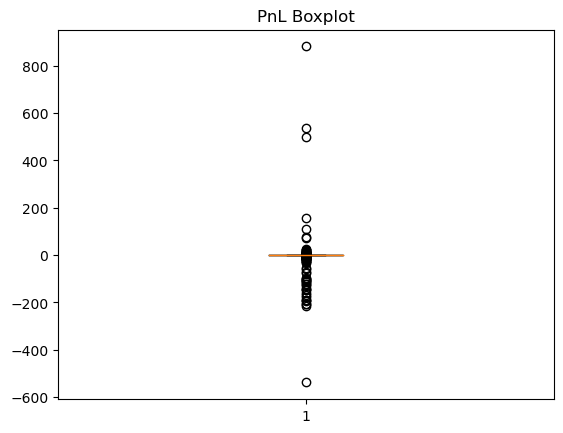

In [21]:
plt.boxplot(df['PnL'])
plt.title("PnL Boxplot")
plt.show()


In [22]:
for strategy_columns in all_strategies:
    strategy_data = df[df[strategy_columns].eq('y').all(axis=1) | df[strategy_columns].eq('n').all(axis=1)]
    if len(strategy_data) != (strategy_data[strategy_columns].eq('y').sum().all() + strategy_data[strategy_columns].eq('n').sum().all()):
        print(f"Strategy {', '.join(strategy_columns)} has inconsistent entries.")


Strategy 2 hours MACD, 4 hours MACD, 8 hours MACD, 3 days MACD, 1 week MACD, 5 minutes MACD, 6 hours MACD, 1 hour MACD, 30 minutes MACD, 12 hours MACD, 1 day MACD, 15 minutes MACD, 15 minutes Bollinger, 15 minutes TSI, 5 minutes EMA, 1 hour KDJ has inconsistent entries.
Strategy 30 minutes KDJ, 30 minutes RSI, 30 minutes Bollinger, 5 minutes MA, 30 minutes TSI, 15 minutes RSI, 5 minutes Bollinger, 5 minutes SuperTrend Vs DEMA, 15 minutes EMA, 15 minutes MA, 1 hour RSI, 1 week KDJ, 5 minutes TSI, 15 minutes KDJ, 3 days TSI, 5 minutes KDJ has inconsistent entries.
Strategy 5 minutes RSI, 1 hour Bollinger, 2 hours KDJ, 15 minutes SuperTrend Vs DEMA, 1 day SuperTrend Vs DEMA, 30 minutes EMA, 3 days RSI, 1 hour TSI has inconsistent entries.


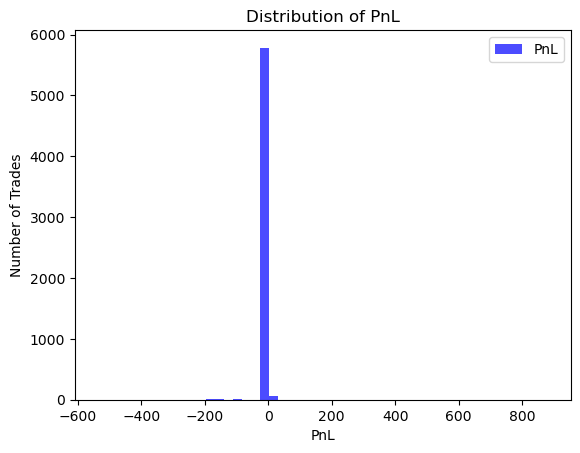

In [23]:
plt.hist(df['PnL'], bins=50, color='blue', alpha=0.7, label='PnL')
plt.title("Distribution of PnL")
plt.xlabel("PnL")
plt.ylabel("Number of Trades")
plt.legend()
plt.show()


In [24]:
def random_strategy(df):
    random_wins = (df.sample(frac=0.5)['PnL'] > 0).sum()
    random_losses = (df.sample(frac=0.5)['PnL'] < 0).sum()
    return random_wins, random_losses

random_wins, random_losses = random_strategy(df)
print(f"Random Strategy - Wins: {random_wins}, Losses: {random_losses}")

Random Strategy - Wins: 723, Losses: 2166


In [25]:
def strategy_performance_over_time(df, timeframe='D'):
    df_resampled = df.resample(timeframe).sum()
    return df_resampled['PnL']

daily_performance = strategy_performance_over_time(df, 'D')
weekly_performance = strategy_performance_over_time(df, 'W')
monthly_performance = strategy_performance_over_time(df, 'M')

daily_performance.plot(label='Daily')
weekly_performance.plot(label='Weekly')
monthly_performance.plot(label='Monthly')
plt.legend()
plt.title("Strategy Performance Over Different Timeframes")
plt.ylabel("PnL")
plt.show()


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'RangeIndex'

In [26]:
df['Price Volatility'] = df['Entry price'].rolling(window=30).std()
high_volatility = df[df['Price Volatility'] > df['Price Volatility'].quantile(0.75)]
low_volatility = df[df['Price Volatility'] < df['Price Volatility'].quantile(0.25)]

high_vol_performance = high_volatility['PnL'].mean()
low_vol_performance = low_volatility['PnL'].mean()

print(f"Performance during high volatility: {high_vol_performance}")
print(f"Performance during low volatility: {low_vol_performance}")


Performance during high volatility: -1.406765190431212
Performance during low volatility: -0.0021975992265571512


Statistical Testing:

- T-Test: This checks if the mean of the profits generated by a strategy is significantly different from 0. This will tell you if your strategy is actually making money on average or if the results could just be due to chance.
Shapiro-Wilk Test: This test will check if your profits are normally distributed, which is an assumption for many statistical methods.
Out-of-Sample Testing:

It's possible for a strategy to overfit to your data. One way to check this is to divide your data into two parts: training and testing. Optimize the strategy on the training data, then check its performance on the testing data.

- Monte Carlo Simulation:

This technique involves simulating multiple scenarios by bootstrapping your data to estimate the uncertainty and variability of your strategy's performance.

- Performance Metrics:

- Sharpe Ratio: This metric will tell you how much excess return you're getting for the extra volatility that you're taking on. A Sharpe ratio greater than 1 is usually considered acceptable to good by investors.
Maximum Drawdown: This will give you an idea of the maximum loss from a peak to a trough.
- Visualization:

Cumulative Returns: Plot the cumulative returns over time. This will give you a visual representation of how your strategy performs over time.
Rolling Statistics: Plot rolling means and standard deviations for your PnL to see if they're stable over time.
- Check for Overfitting:

Look at the number of parameters in your strategy. A strategy with too many parameters is more likely to be overfitting to your data. This is known as the curse of dimensionality.
You can also use techniques like cross-validation to validate the performance of your strategy on different data subsets.
- Benchmarking:

Compare your strategy's performance to a benchmark, like a market index. This will give you a baseline to compare against and determine if your strategy is adding value.

- Backtesting Bias Check:

Ensure that your backtesting methodology doesn't include any biases. Some common biases are lookahead bias, survivorship bias, and data snooping bias.

- Sensitivity Analysis:

Vary the parameters of your strategy slightly to see how sensitive your results are to changes. If small changes result in large performance differences, your strategy may be overfitting to specific data characteristics.

- Compare with a Null Model:
Randomly shuffle your data many times and compute the strategy results. If the results on the shuffled data are often better than the original, your strategy might not have any real predictive power.

In [27]:
from scipy.stats import ttest_1samp

profits = final_result['Overall Profit']
t_stat, p_val = ttest_1samp(profits, 0)
print(f"T-statistic: {t_stat}, P-value: {p_val}")

T-statistic: 2.0175237963735944, P-value: 0.09968467297464523


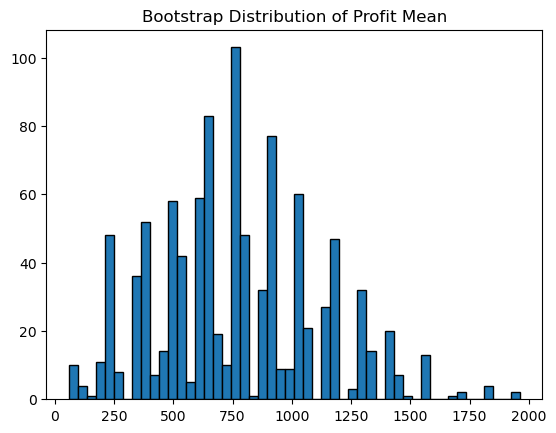

In [28]:
def bootstrap_sample(data, num_samples=1000):
    return [np.random.choice(data, size=len(data), replace=True) for _ in range(num_samples)]

samples = bootstrap_sample(profits)
sample_means = [np.mean(sample) for sample in samples]

plt.hist(sample_means, bins=50, edgecolor='k')
plt.title("Bootstrap Distribution of Profit Mean")
plt.show()


In [29]:
risk_free_rate = 0.02  # Assuming a 2% risk-free rate
daily_returns = profits.pct_change().dropna()  # You might need to adjust for your specific data

sharpe_ratio = (daily_returns.mean() - risk_free_rate) / daily_returns.std()
print(f"Sharpe Ratio: {sharpe_ratio}")


Sharpe Ratio: 0.3934354255834967


In [30]:
cumulative_returns = (1 + profits.pct_change()).cumprod()
drawdown = (cumulative_returns.div(cumulative_returns.cummax()) - 1)
max_drawdown = drawdown.min()
print(f"Maximum Drawdown: {max_drawdown}")

Maximum Drawdown: -0.9910180291212451


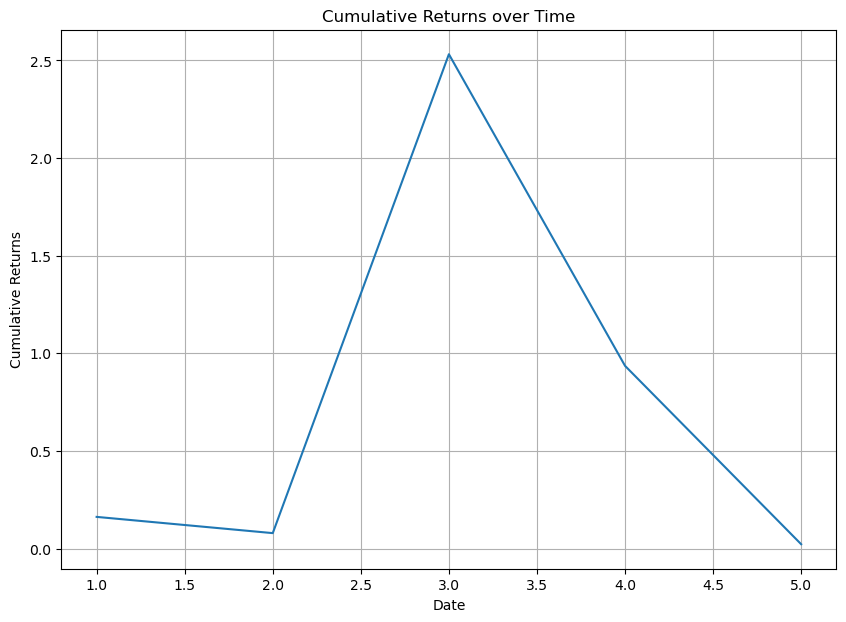

In [31]:
cumulative_returns.plot(figsize=(10, 7))
plt.title('Cumulative Returns over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(True)
plt.show()


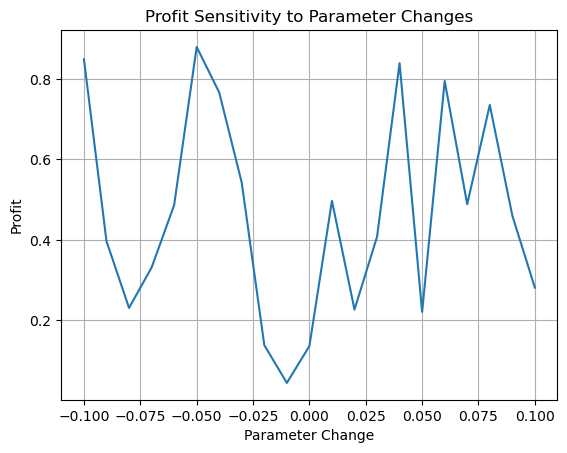

In [32]:
def run_strategy_with_modified_params(param_change):
    # ... Adjust your strategy parameters here ...
    # Return the new profit
    return np.random.rand()  # Dummy return, replace with actual profit calculation

profits_with_changes = [run_strategy_with_modified_params(change) for change in np.linspace(-0.1, 0.1, 21)]
plt.plot(np.linspace(-0.1, 0.1, 21), profits_with_changes)
plt.title('Profit Sensitivity to Parameter Changes')
plt.xlabel('Parameter Change')
plt.ylabel('Profit')
plt.grid(True)
plt.show()


In [63]:

def run_strategy_on_data(df):
    results = defaultdict(lambda: {'Wins': 0, 'Losses': 0, 'Real Entrance': 0, 'Overall Profit': 0})
    
    # Use all columns in df_1 excluding the ones mentioned
    indicator_columns = [col for col in df.columns if col not in ['Strategy name', 'Entry time', 
                                                                    'Symbol', 'Entry price', 'Entry indicators', 
                                                                    'Exit time', 'Exit price', 'PnL %', 'PnL']]
    y_counts = df[indicator_columns].eq('y').sum()
    n_counts = df[indicator_columns].eq('n').sum()
    selected_columns = y_counts[y_counts > n_counts].index.tolist()
    all_strategies = [selected_columns[i:i+16] for i in range(0, len(selected_columns), 16)]
    
    for strategy_columns in all_strategies:
        # strategy_data = df[df[strategy_columns].eq('y').all(axis=1)]
        all_y = df[strategy_columns].eq('y').all(axis=1)
        all_n = df[strategy_columns].eq('n').all(axis=1)
    # 
        strategy_data = df[all_y | all_n]
        if strategy_data.empty:
            continue
        
        strategy_name = ", ".join(strategy_columns)
        wins = (strategy_data['PnL'] > 0).sum()
        losses = (strategy_data['PnL'] <= 0).sum()
    
        real_entrance = max_transactions_count_by_time(strategy_data)
        overall_profit = strategy_data['PnL'].clip(lower=0).sum()
    
        results[strategy_name]['Wins'] += wins
        results[strategy_name]['Losses'] += losses
        results[strategy_name]['Real Entrance'] = real_entrance
        results[strategy_name]['Overall Profit'] = overall_profit
    
    output = []

    for strategy, metrics in results.items():
        C = metrics['Wins']
        D = metrics['Losses']
        E = metrics['Real Entrance']
        B = metrics['Overall Profit']
        F = C + D
        G = C - D
        H = E * 500
        I = (B / H) * 100 if H != 0 else 0
        J = B / (E * 500) * 100 if E != 0 else 0
        K = B / (500 * 150) * 100
        L = (G / F) * 100 if F != 0 else 0
        output.append([strategy, B, C, D, E, F, G, H, I, J, K, L])
    
    columns = [
        'Strategy', 'Overall Profit', 'Wins', 'Losses', 'Real Entrance', 
        'C+D', 'C-D', 'E*500', '(B/H)*100', 'B/(E*500)*100', 'B/(500*150)*100', '(G/F)*100'
    ]
    result_df = pd.DataFrame(output, columns=columns)
    result_df = result_df.sort_values(by='Overall Profit', ascending=False)
    result_df = result_df.reset_index(drop=True)
    return pd.DataFrame(output, columns=columns)
run_strategy_on_data(df)

,Strategy,Overall Profit,Wins,Losses,Real Entrance,C+D,C-D,E*500,(B/H)*100,B/(E*500)*100,B/(500*150)*100,(G/F)*100
0,"5 minutes MACD, 5 minutes RSI, 5 minutes KDJ, ...",77.625615,279,844,47,1123,-565,23500,0.330322,0.330322,0.103501,-50.311665
1,"30 minutes MACD, 30 minutes RSI, 30 minutes KD...",158.718995,175,662,38,837,-487,19000,0.835363,0.835363,0.211625,-58.183990
2,"12 hours MACD, 1 day MACD, 1 day SuperTrend Vs...",975.697800,508,1686,82,2194,-1178,41000,2.379751,2.379751,1.300930,-53.691887


In [50]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

def train_and_evaluate(df):

    if 'Strategy' in df.columns:
        df = df.drop(columns=['Strategy'])

    X = df.drop(columns=['Overall Profit'])
    y = df['Overall Profit']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')

    importance = model.feature_importances_
    for i, j in enumerate(importance):
        print(f'Feature: {X.columns[i]}, Importance: {j}')

In [82]:
summary_df = run_strategy_on_data(df)
train_and_evaluate(summary_df)

Mean Squared Error: 81417.82061143161
Feature: Wins, Importance: 0.15384615384615385
Feature: Losses, Importance: 0.11538461538461539
Feature: Real Entrance, Importance: 0.057692307692307696
Feature: C+D, Importance: 0.11538461538461539
Feature: C-D, Importance: 0.09615384615384616
Feature: E*500, Importance: 0.1346153846153846
Feature: (B/H)*100, Importance: 0.1346153846153846
Feature: B/(E*500)*100, Importance: 0.07692307692307693
Feature: B/(500*150)*100, Importance: 0.057692307692307696
Feature: (G/F)*100, Importance: 0.057692307692307696


In [80]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

train_df, test_df = train_test_split(df, test_size=0.3, shuffle=False)
tscv = TimeSeriesSplit(n_splits=5)
all_results = []

for train_index, test_index in tscv.split(df):
    train_df, test_df = df.iloc[train_index], df.iloc[test_index]
    
    train_results = run_strategy_on_data(train_df)
    test_results = run_strategy_on_data(test_df)
    
    all_results.append({
        'train': train_results,
        'test': test_results
    })

def display_summary(results):
    for idx, res in enumerate(results):
        train_profit = res['train']['Overall Profit'].sum()
        test_profit = res['test']['Overall Profit'].sum()
        print(f"Split {idx+1} - Train Profit: {train_profit}, Test Profit: {test_profit}")

display_summary(all_results)

def extract_trades_and_calculate_accuracy(df):
    trades = df[df['Overall Profit'] != 0]  # Assuming a trade with a non-zero PnL value is a completed trade.
    trades['Prediction Accuracy'] = (trades['Wins'] / (trades['Wins'] + trades['Losses'])) * 100
    return trades

split_4_test_trades = extract_trades_and_calculate_accuracy(all_results[3]['test'])
split_4_test_trades

Split 1 - Train Profit: 0.0, Test Profit: 0.0
Split 2 - Train Profit: 0.0, Test Profit: 0.0
Split 3 - Train Profit: 0.0, Test Profit: 0.0
Split 4 - Train Profit: 0.0, Test Profit: 330.61662612
Split 5 - Train Profit: 87.074356, Test Profit: 1833.610709


,Strategy,Overall Profit,Wins,Losses,Real Entrance,C+D,C-D,E*500,(B/H)*100,B/(E*500)*100,B/(500*150)*100,(G/F)*100,Prediction Accuracy
0,"5 minutes MACD, 5 minutes RSI, 5 minutes KDJ, ...",22.316510,91,88,14,179,3,7000,0.318807,0.318807,0.029755,1.675978,50.837989
1,"30 minutes MACD, 30 minutes RSI, 30 minutes KD...",20.501950,46,55,17,101,-9,8500,0.241199,0.241199,0.027336,-8.910891,45.544554
2,"6 hours MACD, 8 hours MACD, 12 hours MACD, 1 d...",287.798166,194,238,28,432,-44,14000,2.055701,2.055701,0.383731,-10.185185,44.907407


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd

def train_and_evaluate(df):

    strategies = df['Strategy']

    df = df.drop(columns=['Strategy'])

    categories = ['Overall Profit', 'Wins', 'Losses', 'Real Entrance']
    for cat in categories:
        X = df.drop(columns=categories)
        y = df[cat]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        y_pred = model.predict(X)
        df[f'Predicted {cat}'] = y_pred

        test_mse = mean_squared_error(y_test, model.predict(X_test))
        print(f'Mean Squared Error for {cat} on Test Set: {test_mse}')

        importance = model.feature_importances_
        print(f"\nFeature Importances for {cat}:")
        for i, j in enumerate(importance):
            print(f'Feature: {X.columns[i]}, Importance: {j}')
        print("\n" + "-"*50 + "\n")

    df['Strategy'] = strategies

    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df = df[cols]

    print(df)

    return df

df = run_strategy_on_data(df)  
predicted_df = train_and_evaluate(df)

Mean Squared Error for Overall Profit on Test Set: 106397.97299504165

Feature Importances for Overall Profit:
Feature: C+D, Importance: 0.13461538461538464
Feature: C-D, Importance: 0.21153846153846156
Feature: E*500, Importance: 0.1730769230769231
Feature: (B/H)*100, Importance: 0.07692307692307694
Feature: B/(E*500)*100, Importance: 0.09615384615384617
Feature: B/(500*150)*100, Importance: 0.15384615384615388
Feature: (G/F)*100, Importance: 0.15384615384615388

--------------------------------------------------

Mean Squared Error for Wins on Test Set: 430.5625

Feature Importances for Wins:
Feature: C+D, Importance: 0.1346153846153846
Feature: C-D, Importance: 0.15384615384615385
Feature: E*500, Importance: 0.19230769230769232
Feature: (B/H)*100, Importance: 0.09615384615384616
Feature: B/(E*500)*100, Importance: 0.11538461538461539
Feature: B/(500*150)*100, Importance: 0.15384615384615385
Feature: (G/F)*100, Importance: 0.057692307692307696
Feature: Predicted Overall Profit, Impor

In [71]:
predicted_df

,Strategy,Overall Profit,Wins,Losses,Real Entrance,C+D,C-D,E*500,(B/H)*100,B/(E*500)*100,B/(500*150)*100,(G/F)*100,Predicted Overall Profit,Predicted Wins,Predicted Losses,Predicted Real Entrance
0,"1 minute MACD, 1 minute RSI, 1 minute KDJ, 1 m...",2689.361782,1422,4451,147,5873,-3029,73500,3.658996,3.658996,3.585816,-51.575004,2502.307061,1327.44,4159.31,138.28
1,"5 minutes MACD, 5 minutes RSI, 5 minutes KDJ, ...",77.625615,279,844,47,1123,-565,23500,0.330322,0.330322,0.103501,-50.311665,282.314339,123.38,515.01,34.33
2,"30 minutes MACD, 30 minutes RSI, 30 minutes KD...",5.684405,77,284,27,361,-207,13500,0.042107,0.042107,0.007579,-57.340720,87.666902,58.94,264.85,24.87
3,"2 hours MACD, 2 hours RSI, 2 hours KDJ, 2 hour...",3.862170,27,126,11,153,-99,5500,0.070221,0.070221,0.005150,-64.705882,4.600500,26.27,122.90,10.02
4,"6 hours MACD, 6 hours RSI, 6 hours KDJ, 6 hour...",22.102748,36,129,11,165,-93,5500,0.401868,0.401868,0.029470,-56.363636,95.695675,36.89,182.08,16.14
5,"12 hours MACD, 12 hours RSI, 12 hours KDJ, 12 ...",2.997484,40,127,27,167,-87,13500,0.022204,0.022204,0.003997,-52.095808,276.933616,108.70,462.63,32.21
6,"3 days MACD, 3 days RSI, 3 days KDJ, 3 days EM...",0.016970,5,30,2,35,-25,1000,0.001697,0.001697,0.000023,-71.428571,2.106621,18.35,74.44,5.93
7,"1 month MACD, 1 month RSI, 1 month KDJ, 1 mont...",2689.361782,1422,4451,147,5873,-3029,73500,3.658996,3.658996,3.585816,-51.575004,2502.307061,1327.44,4159.31,138.28
